In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import colors
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry

In [2]:
df_str = pd.read_csv("csv/iza_bulk.csv")
df_dft = pd.read_csv("csv/dft.csv")
df_hal = pd.read_csv("csv/hal.csv")
cif = df_str["cif"]

In [3]:
print(len(df_str))
print(len(df_dft))
print(len(df_hal))

230
195
189


In [4]:
df = pd.merge(df_str, df_dft, left_on="cif", right_on="name")
df = pd.merge(df, df_hal, left_on="cif", right_on="REFCODE")
df.drop(columns=["REFCODE", "Unnamed: 0"], inplace=True)
df.head(3)

cif       pld       lcd       asa         av  psd mean   psd std  n_paths  \
0  ABW  2.476562  4.242640   2824.94   1546.396  0.994927  0.524161    589.0   
1  ACO  3.601562  4.604346   5859.62   3399.968  1.090194  0.590122    550.0   
2  AEI  3.601562  7.337575  19212.96  15170.100  1.418122  0.816693   2376.0   

   paths mean  paths std         ...          ydim  zdim  n_channels  name  \
0    1.690595   0.268248         ...           9.5  16.8         1.0   ABW   
1    1.732020   0.351302         ...          18.6  18.4         1.0   ACO   
2    1.444696   0.115261         ...          25.6  36.9         1.0   AEI   

       g_gbr      k_gbr  Kh(mmol/gratm) CH4  Ener_dif(kJ/mol)CH4  \
0  42.398400  89.876943            0.497018            10.325025   
1  31.407661  90.180304            0.966936             9.091395   
2  25.204138  50.301074            0.569469             5.686089   

   Kh(mmol/gratm)H2  Ener_dif(kJ/mol)H2  
0          0.023497            1.007867  
1          0.029636            0.230720  
2          0.027799            1.736061  

[3 rows x 21 columns]

In [5]:
df.describe()

pld         lcd            asa             av    psd mean  \
count  176.000000  176.000000     176.000000     176.000000  176.000000   
mean     3.892401    7.039020   22770.755511   15999.095909    1.207312   
std      1.841863    1.983918   32521.690307   24665.589884    0.205130   
min      1.210938    3.934463    1566.230000    1012.192000    0.777344   
25%      2.476562    5.651541    9179.857500    5761.109500    1.078794   
50%      3.460938    6.823466   14058.965000    8948.731500    1.190307   
75%      5.007812    7.932837   25255.370000   17914.989500    1.301222   
max     11.335938   16.340136  298184.570000  210413.866000    2.383693   

          psd std        n_paths  paths mean   paths std        xdim  \
count  176.000000     176.000000  176.000000  176.000000  176.000000   
mean     0.716161   15721.437500    1.960278    0.399933   28.794318   
std      0.195019   28920.373255    0.645996    0.335590   13.000843   
min      0.413235      75.000000    1.203412    0.029203    9.500000   
25%      0.586868    2077.750000    1.486708    0.142050   18.975000   
50%      0.681892    5117.000000    1.714635    0.294851   26.500000   
75%      0.801357   15736.250000    2.291315    0.547774   35.925000   
max      1.647325  170502.000000    4.041914    1.634035   83.600000   

             ydim        zdim  n_channels       g_gbr       k_gbr  \
count  176.000000  176.000000       176.0  176.000000  176.000000   
mean    29.140341   29.819318         1.0   26.950782   57.116301   
std     13.921105   16.833781         0.0    6.948392   16.521939   
min      9.500000    9.300000         1.0   12.702315   25.192129   
25%     21.575000   16.775000         1.0   22.430246   45.567185   
50%     26.200000   26.000000         1.0   25.525353   53.153815   
75%     35.475000   39.475000         1.0   29.025547   65.053399   
max    113.700000   82.900000         1.0   51.336274  107.574425   

       Kh(mmol/gratm) CH4  Ener_dif(kJ/mol)CH4  Kh(mmol/gratm)H2  \
count          176.000000           176.000000        176.000000   
mean             0.748964           522.757506          0.021588   
std              0.588726          6267.012499          0.005256   
min              0.001709             0.018822          0.009386   
25%              0.438936             1.857674          0.017998   
50%              0.604243             4.218884          0.021556   
75%              0.951124            11.471468          0.025599   
max              4.406606         83167.578125          0.048816   

       Ener_dif(kJ/mol)H2  
count          176.000000  
mean           475.306832  
std           6267.585424  
min              0.003713  
25%              0.449076  
50%              0.954462  
75%              1.781171  
max          83151.726562

In [6]:
pore_data = sio.loadmat("csv/iza_bulk_data.mat")

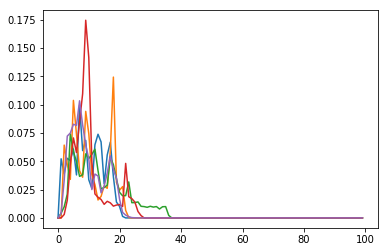

In [103]:
psd_list = pore_data["psd"][0]
path_list = pore_data["paths"][0]
areas = pore_data["areas"][0]
vols = pore_data["vols"][0]

nbins = 100
psd_norm = np.zeros((len(psd_list), nbins))
psd_mean_H2 = []
psd_mean_ch4 = []
for indx, psd in enumerate(psd_list):
    psd_norm[indx, :] = np.histogram(psd, bins=nbins, range=(0,10))[0] / len(psd[0])
    psd_mean_H2.append(np.mean(psd[0]))
    psd_mean_ch4.append(np.mean(psd[0][psd[0]>1]))

    
indxs =  np.asarray(df_str["cif"][df_str["cif"].isin(df["cif"])].index)
psd_norm = psd_norm[indxs]
psd_mean_H2 = np.asarray(psd_mean_H2)[indxs]
psd_mean_ch4 = np.asarray(psd_mean_ch4)[indxs]
vols = vols[indxs]
areas = areas[indxs]
for psd in psd_norm[:5]:
    plt.plot(psd)
plt.show()

In [114]:
av = df["av"] / vols
asa = df["asa"] / areas

In [60]:
np.corrcoef(psd_mean_H2, df["Kh(mmol/gratm)H2"])

array([[1.       , 0.7207255],
       [0.7207255, 1.       ]])

In [89]:
np.corrcoef(df["lcd"], df["Kh(mmol/gratm) CH4"])

array([[ 1.        , -0.13623807],
       [-0.13623807,  1.        ]])

In [113]:
indxs_ = df["Kh(mmol/gratm) CH4"] < 0.3
print(np.count_nonzero(indxs_))
np.corrcoef(df["psd mean"][indxs_], df["Kh(mmol/gratm) CH4"][indxs_])

22


array([[1.        , 0.35895957],
       [0.35895957, 1.        ]])

In [111]:
np.corrcoef(df["av"][indxs_], np.log(df["Kh(mmol/gratm) CH4"][indxs_]))

array([[1.        , 0.37802502],
       [0.37802502, 1.        ]])

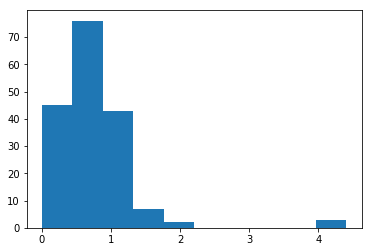

In [83]:
plt.hist(df["Kh(mmol/gratm) CH4"])
plt.show()

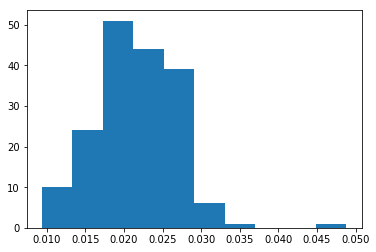

In [82]:
plt.hist(df["Kh(mmol/gratm)H2"])
plt.show()

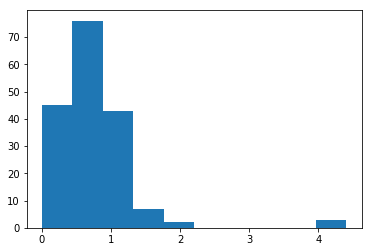

In [80]:
plt.hist(df["Kh(mmol/gratm) CH4"])
plt.show()

In [77]:
x = df["psd mean"][df["pld"]<2.5]
y = df["Kh(mmol/gratm) CH4"][df["pld"]<2.5]
np.corrcoef(x, y)

array([[1.        , 0.44745818],
       [0.44745818, 1.        ]])